In [125]:
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

In [ ]:
names = open('names.txt', 'r').read().splitlines()
len(names)
# min(len(n) for n in names)
# max(len(n) for n in names)

15

# BiGram

В первую очередь стоит посмотреть на наши биграмы и понять, что они из себя представляют

In [87]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [88]:
chars = sorted(list(set(''.join(names))))
n2i = {n:i+1 for i, n in enumerate(chars)}
n2i['.'] = 0
i2n = {i:n for n, i in n2i.items()}

In [89]:
for n in names:
    chs = ['.']  + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = n2i[ch1]
        ix2 = n2i[ch2]
        N[ix1][ix2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

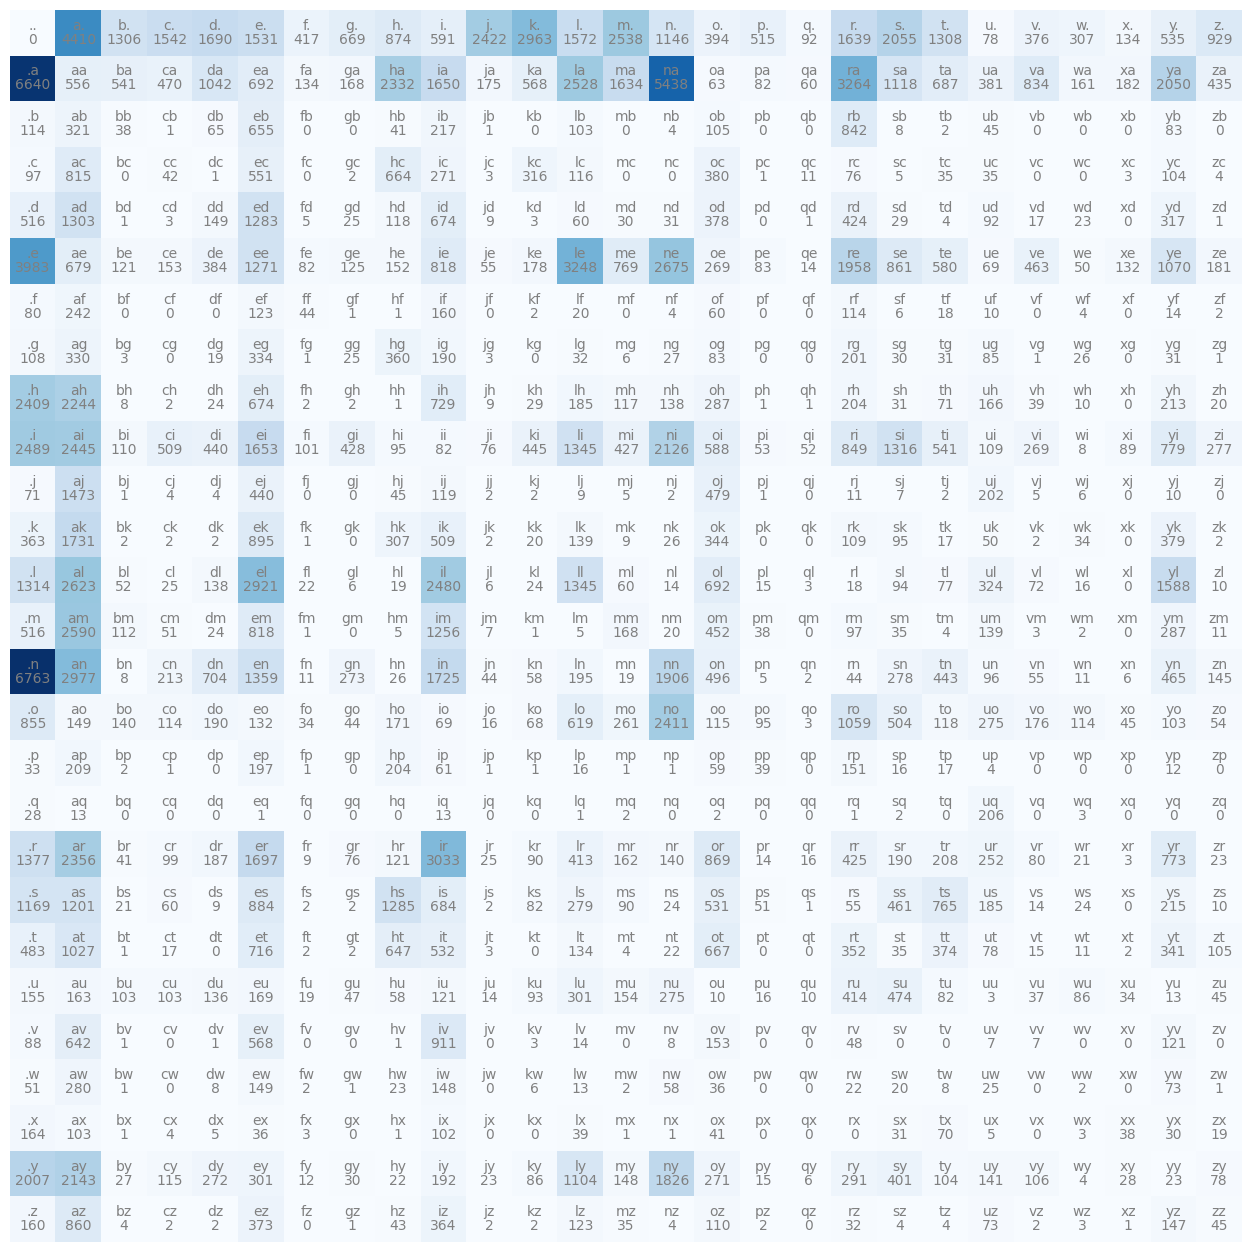

In [90]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chrstr = i2n[i] + i2n[j]
        plt.text(i, j, chrstr, ha='center', va='bottom', color='grey')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='grey')
plt.axis('off')

In [118]:
P = (N+1).float() # +1 для фикса проблемы, когда сочетание букв встречается ноль раз и loss становится бесконечным
P /= P.sum(dim=1, keepdim=True)

In [119]:
g  = torch.Generator().manual_seed(42)

for i in range(5):
    idx = 0
    out = []
    while True:
        p = P[idx]
        
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(i2n[idx])
        if idx == 0:
            break
    print(''.join(out[:-1]))

anugeenvi
s
mabidushan
stan
silaylelaremah


In [121]:
neg_log_like = 0
count = 0
for n in names:
# for n in ['fedorjq']:
    chs = ['.']  + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = n2i[ch1]
        ix2 = n2i[ch2]
        prob = P[ix1][ix2]
        logprob = -torch.log(prob)
        neg_log_like += logprob
        count+=1
        # print(f'{ch1}{ch2}, {prob:.4f}, {logprob:.4f}')
print(f'AVG Neg Log Likelehood = {neg_log_like/count:.4f}')

AVG Neg Log Likelehood = 2.4544


In [223]:
#создание тренировочного датасета
xs, ys = [], []
for n in names:
    chs = ['.']  + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = n2i[ch1]
        ix2 = n2i[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [222]:
#training loop
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator=g, requires_grad=True)

for k in range(1000):
    #forward pass
    xsenc = one_hot(xs, num_classes=27).float()
    logits = (xsenc @ W)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(228146), ys].log().mean()

    #backward pass
    W.grad = None
    loss.backward()

    W.data += -50 * W.grad

print(f'Loss: {loss}')

Loss: 2.4553425312042236


In [225]:
g  = torch.Generator().manual_seed(42)

for i in range(5):
    idx = 0
    out = []
    while True:
        xsenc = one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = (xsenc @ W)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(i2n[idx])
        if idx == 0:
            break
    print(''.join(out[:-1]))

anugeenvi
s
mabian
dan
stan
